In [1]:
# Cell 0: This Cell will serve to load any lybraries I will need throughout my project. This Helps me keep everything neat. 

# Basic data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier


# PyTorch for model building and training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Additional tools
import os  # For directory and file operations
import sys  # For system-specific parameters and functions

In [2]:
#Cell 1: Import new cleaned CSV

# Replace the file path with your specific file location
file_path = r'C:\Users\gsmit\OneDrive\Desktop\CS691 Project Codename Prayer\cleaned_datasetV2.csv'
df = pd.read_csv(file_path)

# Display the first few rows to ensure it's loaded correctly
print(df.head())


    Source Port   Destination Port   Protocol   Flow Duration  \
0           634              -5041         17           28415   
1           634              -5041         17               2   
2           634             -19145         17           48549   
3           634              11894         17           48337   
4           634              27878         17           32026   

    Total Fwd Packets   Total Backward Packets  Total Length of Fwd Packets  \
0                  97                        0                      42680.0   
1                   2                        0                        880.0   
2                 200                        0                      88000.0   
3                 200                        0                      88000.0   
4                 200                        0                      88000.0   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                           0.0                   440.0   
1               

In [3]:
# Cell 2: Check if CUDA is available and set the device accordingly
# Specify the GPU device
if torch.cuda.is_available():
    print("Available CUDA devices:")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)} with {torch.cuda.get_device_properties(i).total_memory / 1e9} GB")
else:
    print("No CUDA devices available.")

print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Available CUDA devices:
Device 0: NVIDIA GeForce RTX 3050 Laptop GPU with 4.294508544 GB
1
Using cuda:0 device


Unique labels in the dataset: ['DrDoS_DNS' 'BENIGN' 'DrDoS_LDAP' 'DrDoS_MSSQL' 'DrDoS_NetBIOS'
 'DrDoS_NTP' 'DrDoS_SNMP' 'DrDoS_SSDP' 'DrDoS_UDP' 'NetBIOS' 'LDAP'
 'MSSQL' 'Portmap' 'Syn' 'TFTP' 'UDP' 'UDP-lag' 'WebDDoS' 'UDPLag']
Value counts of each label:
  Label
TFTP             15750745
MSSQL             5563090
Syn               5495865
DrDoS_SNMP        4772055
DrDoS_DNS         4527409
DrDoS_MSSQL       4376070
UDP               3789881
DrDoS_NetBIOS     3608010
NetBIOS           3280843
DrDoS_UDP         3093625
DrDoS_SSDP        2568353
DrDoS_LDAP        1982487
LDAP              1719799
DrDoS_NTP         1195356
UDP-lag            330026
Portmap            177165
BENIGN             107028
UDPLag               1572
WebDDoS               439
Name: count, dtype: int64


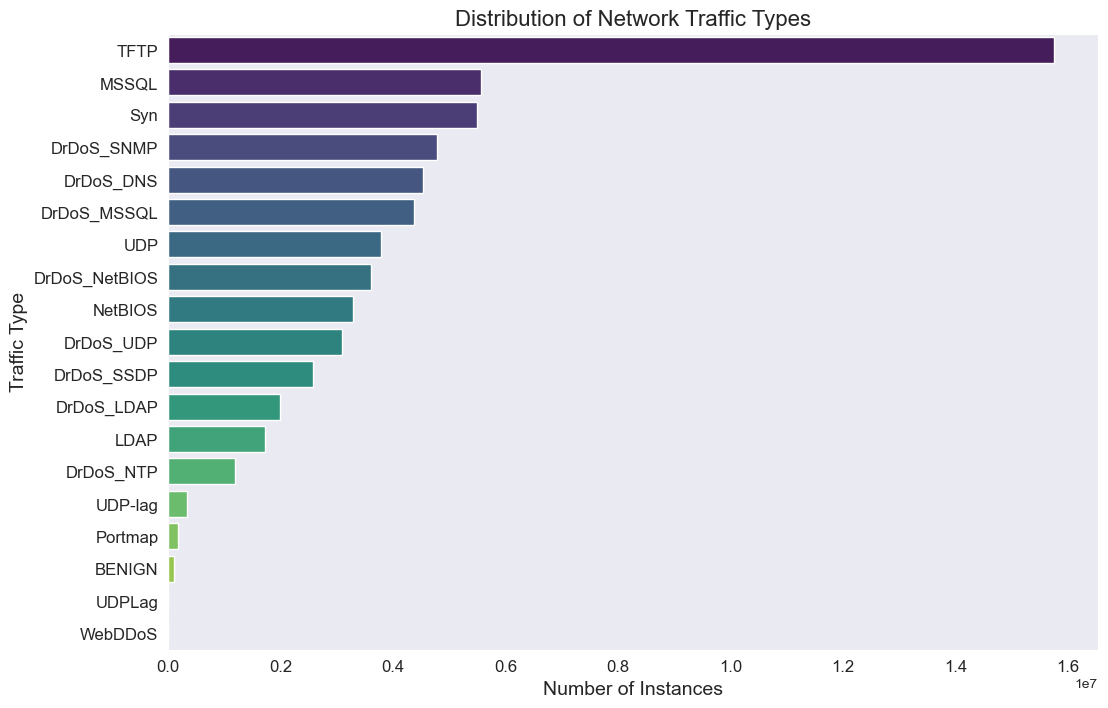

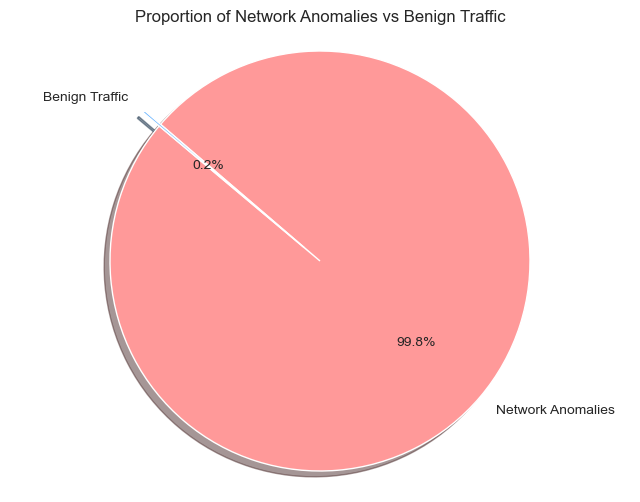

In [4]:
# Cell 3: Print the 'Label' feature

print("Unique labels in the dataset:", df[' Label'].unique())  # Note the leading space in ' Label'
print("Value counts of each label:\n", df[' Label'].value_counts())  # Note the leading space in ' Label'

class_distribution = df[' Label'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=class_distribution.values, y=class_distribution.index, palette='viridis')
plt.title('Distribution of Network Traffic Types', fontsize=16)
plt.xlabel('Number of Instances', fontsize=14)
plt.ylabel('Traffic Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')

plt.show()

benign_count = df[' Label'].value_counts()['BENIGN']

# Calculate the count of all network anomalies by subtracting benign traffic from total
total_traffic_count = df[' Label'].value_counts().sum()
anomalies_count = total_traffic_count - benign_count

# Data to plot
labels = ['Network Anomalies', 'Benign Traffic']
sizes = [anomalies_count, benign_count]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Network Anomalies vs Benign Traffic')
plt.show()


In [5]:
# Cell 4: Addressing class imbalance with SMOTE

# Import necessary library for SMOTE
#from imblearn.over_sampling import SMOTE
#from sklearn.preprocessing import LabelEncoder

# Ensure all categorical data is encoded
#label_encoder = LabelEncoder()
#df[' Label'] = label_encoder.fit_transform(df[' Label'])

# Define your features and target variable
#X = df.drop(' Label', axis=1)  # Features
#y = df[' Label']  # Target variable

 #Initializing SMOTE
#smote = SMOTE()

# Applying SMOTE to your data and creating a new balanced dataset
#X_smote, y_smote = smote.fit_resample(X, y)

# Check the balanced dataset
#print("After SMOTE, counts of label '1': {}".format(sum(y_smote == 1)))
#print("After SMOTE, counts of label '0': {}".format(sum(y_smote == 0)))

# Proceed to split your dataset into training and testing sets
#from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
#X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

#print("Training set shape: ", X_train.shape, y_train.shape)
#print("Testing set shape: ", X_test.shape, y_test.shape)


In [6]:
#Cell 5: Splitting Data into Training and Test 

X = df.drop(' Label', axis=1)  # Features
y = df[' Label']  # Target variable

# Encoding the categorical target variable to numeric
y_encoded = LabelEncoder().fit_transform(y)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (49871854, 44), (49871854,)
Test set shape: (12467964, 44), (12467964,)


In [7]:
# Cell 6: Define the Neural Network Model
class BasicNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasicNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)  # Adjust input layer to hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.layer2 = nn.Linear(64, output_size)  # Adjust hidden layer to output layer

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Specify the input and output dimensions based on your dataset
input_size = 44  # Adjust this based on the number of features in your dataset
output_size = len(np.unique(y_train))  # Adjust this based on the number of unique labels/classes

# Instantiate the model
model = BasicNN(input_size, output_size)
print("Model defined.")

Model defined.


In [8]:
# Cell 7: Move the Model to the Appropriate Device
model = model.to(device)
print(f"Model moved to {device}.")

# Convert the training dataset to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

Model moved to cuda:0.


In [9]:
# Cell 8: Train the Model

from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train_tensor and y_train_tensor have already been moved to the appropriate device
# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)  # Adjust batch_size as needed

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted

# Define the training function
def train_model(model, criterion, optimizer, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Log the loss
        if (epoch+1) % 1 == 0:  # Adjust the logging frequency as needed
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the model
train_model(model, criterion, optimizer, train_loader, epochs=10)


Epoch [1/10], Loss: 2.4615
Epoch [2/10], Loss: 2.2613
Epoch [3/10], Loss: 2.3484
Epoch [4/10], Loss: 2.4852
Epoch [5/10], Loss: 2.5060
Epoch [6/10], Loss: 2.3354
Epoch [7/10], Loss: 2.5241
Epoch [8/10], Loss: 2.4470
Epoch [9/10], Loss: 2.3976
Epoch [10/10], Loss: 2.4368


In [10]:
# Cell 9: Move Model to CPU
model = model.to('cpu')
print("Model moved to CPU.")


Model moved to CPU.


In [11]:
# Cell 10: Evaluate Model on CPU

# Ensure data is in CPU for evaluation
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).to('cpu')
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to('cpu')

# Evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

    # Calculate accuracy
    correct_predictions = (predictions == y_test_tensor).sum().item()
    total_predictions = y_test_tensor.size(0)
    accuracy = 100 * correct_predictions / total_predictions
    print(f'Accuracy on test set: {accuracy:.2f}%')


Accuracy on test set: 25.27%


C:\Users\gsmit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2527
Precision: 0.0948
Recall: 0.2527
F1 Score: 0.1019


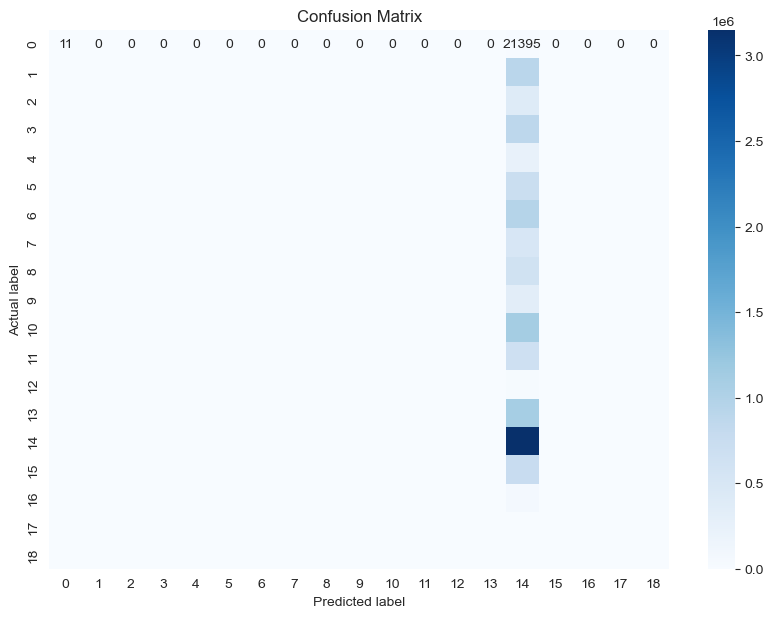

In [12]:
# Enhanced Cell 11: Evaluate Model with Additional Performance Measures

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Ensure data is in CPU for evaluation
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).to('cpu')
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to('cpu')

# Evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

    # Convert predictions and actuals to NumPy arrays for sklearn metrics
    predictions_np = predictions.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate accuracy
    accuracy = accuracy_score(y_test_np, predictions_np)
    precision = precision_score(y_test_np, predictions_np, average='weighted')
    recall = recall_score(y_test_np, predictions_np, average='weighted')
    f1 = f1_score(y_test_np, predictions_np, average='weighted')

    # Display metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, predictions_np)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


In [13]:
# Cell 12: Create a new DataFrame df2 by copying df

df2 = df.copy()

# Display the first few rows to ensure it's copied correctly
print(df2.head())


    Source Port   Destination Port   Protocol   Flow Duration  \
0           634              -5041         17           28415   
1           634              -5041         17               2   
2           634             -19145         17           48549   
3           634              11894         17           48337   
4           634              27878         17           32026   

    Total Fwd Packets   Total Backward Packets  Total Length of Fwd Packets  \
0                  97                        0                      42680.0   
1                   2                        0                        880.0   
2                 200                        0                      88000.0   
3                 200                        0                      88000.0   
4                 200                        0                      88000.0   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                           0.0                   440.0   
1               

In [14]:
# Cell 13: Clearing DataFrame 'df' from memory

# Delete the DataFrame
del df

# Import the garbage collector module
import gc

# Manually trigger garbage collection
gc.collect()

print("DataFrame 'df' has been deleted and memory cleared.")


DataFrame 'df' has been deleted and memory cleared.


In [15]:
# Cell 14: Analyzing the new DataFrame df2

# Print the shape of df2
print("Shape of df2:", df2.shape)

# Display descriptive statistics for df2
print("\nDescriptive Statistics of df2:")
print(df2.describe())

# Count the number of unique labels and their occurrence
label_counts = df2[' Label'].value_counts()  # Corrected 'Label' to ' Label' to match the actual column name
print("\nNumber of unique labels:", df2[' Label'].nunique())  # Same adjustment as above
print("\nCounts of each label:")
print(label_counts)


Shape of df2: (62339818, 45)

Descriptive Statistics of df2:
        Source Port   Destination Port      Protocol   Flow Duration  \
count  6.233982e+07       6.233982e+07  6.233982e+07    6.233982e+07   
mean  -3.210768e+03      -9.897763e+00  1.594038e+01    1.308272e+06   
std    1.263116e+04       1.892352e+04  3.246191e+00    6.790479e+06   
min   -3.276800e+04      -3.276800e+04  0.000000e+00    1.000000e+00   
25%   -7.339000e+03      -1.639500e+04  1.700000e+01    1.000000e+00   
50%   -1.835000e+03      -8.100000e+01  1.700000e+01    2.000000e+00   
75%    8.330000e+02       1.641600e+04  1.700000e+01    1.057240e+05   
max    3.276700e+04       3.276700e+04  1.700000e+01    1.200000e+08   

        Total Fwd Packets   Total Backward Packets  \
count        6.233982e+07             6.233982e+07   
mean         4.067402e+00             1.025121e-01   
std          7.019491e+01             4.741569e+00   
min         -3.244500e+04             0.000000e+00   
25%          2.00000

In [16]:
# Cell 15: Create a new DataFrame df3 with only TCP-based attacks and Benign traffic

# Define the labels for TCP based attacks from the image provided
tcp_based_attacks = ['MSSQL', 'DrDoS_SSDP']

# Include benign traffic
tcp_based_attacks.append('BENIGN')

# Filter df2 for these specific attacks and benign traffic
df3 = df2[df2[' Label'].isin(tcp_based_attacks)]

# Check the new shape and the balance of the labels
print("Shape of df3:", df3.shape)
print("\nCounts of each label in df3:")
print(df3[' Label'].value_counts())


Shape of df3: (8238471, 45)

Counts of each label in df3:
 Label
MSSQL         5563090
DrDoS_SSDP    2568353
BENIGN         107028
Name: count, dtype: int64


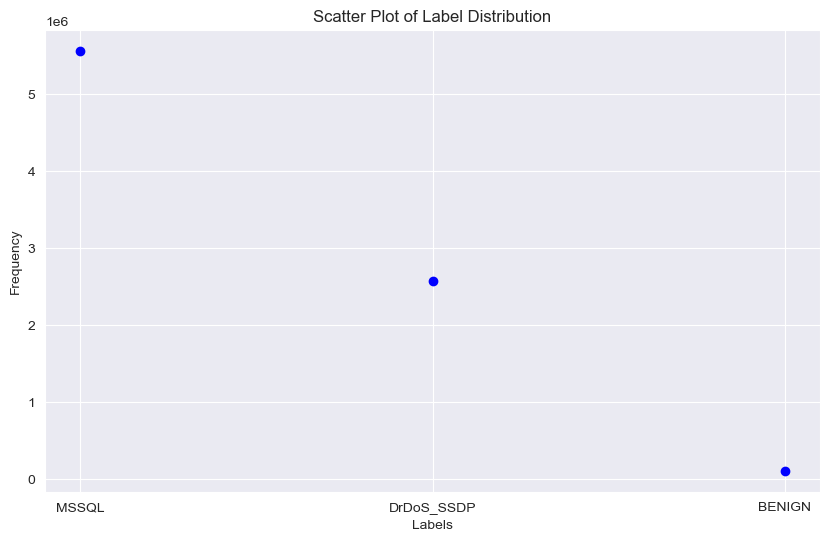

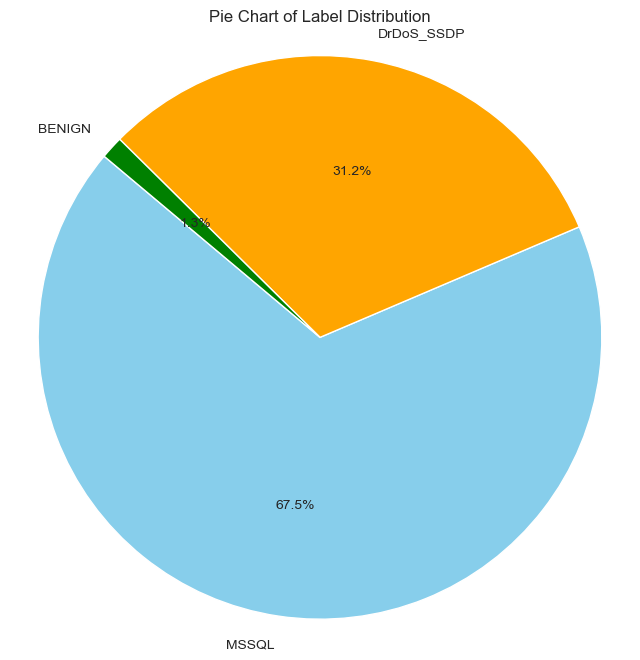

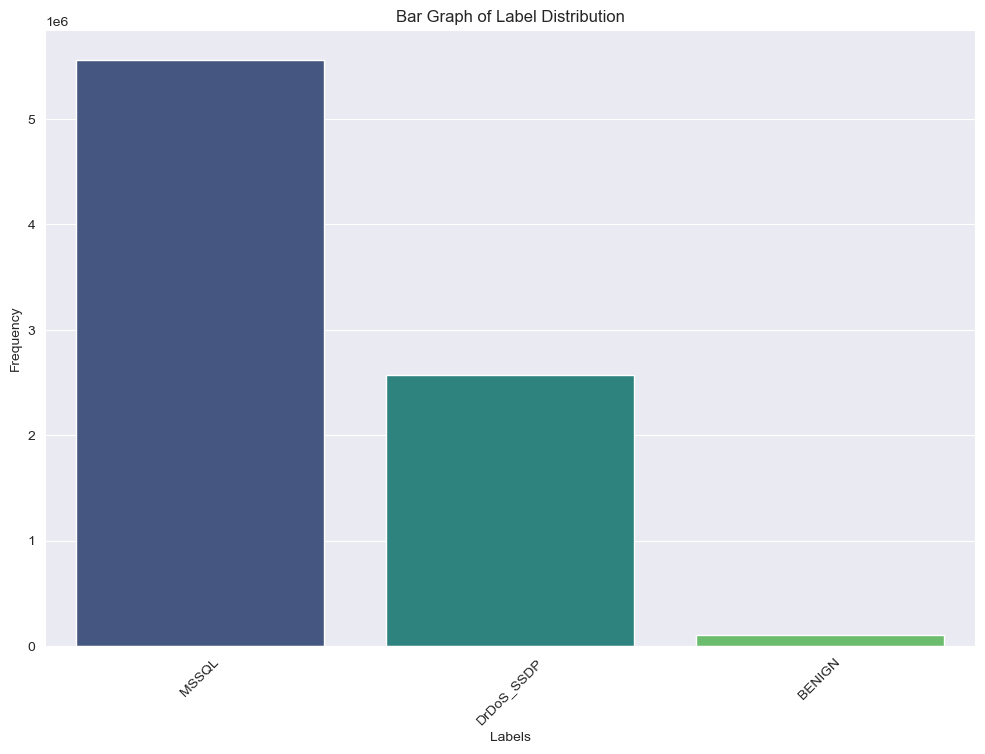

In [17]:
# Cell 16: Visualizing the distribution of the target variable in df3


# Assuming ' Label' is the target variable and it has leading space as before
label_counts = df3[' Label'].value_counts()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(label_counts.index, label_counts.values, color='blue')
plt.title('Scatter Plot of Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'green'])
plt.title('Pie Chart of Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

# Bar Graph
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Bar Graph of Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [18]:
# Cell 17: Splitting df3 Data into Training and Testing Sets

from sklearn.preprocessing import LabelEncoder

# Features and Labels
X = df3.drop(' Label', axis=1)
y = df3[' Label']

# Encoding the Labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Printing shapes of the splits
print(f'Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}')


Training set shape: X_train: (6590776, 44), y_train: (6590776,)
Test set shape: X_test: (1647695, 44), y_test: (1647695,)


In [21]:
# Cell 18: Define the Neural Network Model for df3

def __init__(self, input_size, output_size):
    super(BasicNN, self).__init__()
    self.layer1 = nn.Linear(input_size, 64)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(64, output_size)
    self.sigmoid = nn.Sigmoid()  # Only use if output_size == 1 for binary classification
    self.initialize_weights()

def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.layer2(x)
    if self.layer2.out_features == 1:  # Assuming binary classification
        x = self.sigmoid(x)
    return x

def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to the correct device
model = BasicNN(input_size=X_train.shape[1], output_size=len(np.unique(y_train)))
model.to(device)

print("Model defined.")


Model defined.


In [22]:
# Cell 19: Train the Model on df3

# Convert the training dataset to PyTorch tensors and move to the device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)  # Adjust batch_size as needed

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Train the model
def train_model(model, criterion, optimizer, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Logging
        if (epoch+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Run the training function
train_model(model, criterion, optimizer, train_loader, epochs=10)


Epoch [1/10], Loss: 0.3786
Epoch [2/10], Loss: 0.4730
Epoch [3/10], Loss: 0.4242
Epoch [4/10], Loss: 0.4406
Epoch [5/10], Loss: 0.5441
Epoch [6/10], Loss: 0.4821
Epoch [7/10], Loss: 0.7701
Epoch [8/10], Loss: 0.6213
Epoch [9/10], Loss: 0.7090
Epoch [10/10], Loss: 0.7375


In [23]:
# Cell 20: Evaluate the Model on the Test Set of df3

# Move the model to CPU for evaluation (if it's on GPU)
model = model.to('cpu')

# Ensure data is in CPU for evaluation
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).to('cpu')
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to('cpu')

# Evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

    # Calculate accuracy
    accuracy = (predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')


Accuracy on test set: 0.68


In [24]:
# Cell 21: Enhanced Evaluation with Additional Performance Measures

# Ensure data is in CPU for evaluation
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).to('cpu')
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to('cpu')

# Evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

    # Convert predictions and y_test to NumPy arrays for sklearn metrics
    predictions_np = predictions.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test_np, predictions_np, average='weighted')
    recall = recall_score(y_test_np, predictions_np, average='weighted')
    f1 = f1_score(y_test_np, predictions_np, average='weighted')

    # Display metrics
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')



Accuracy: 0.68
Precision: 0.6446
Recall: 0.6808
F1 Score: 0.5539


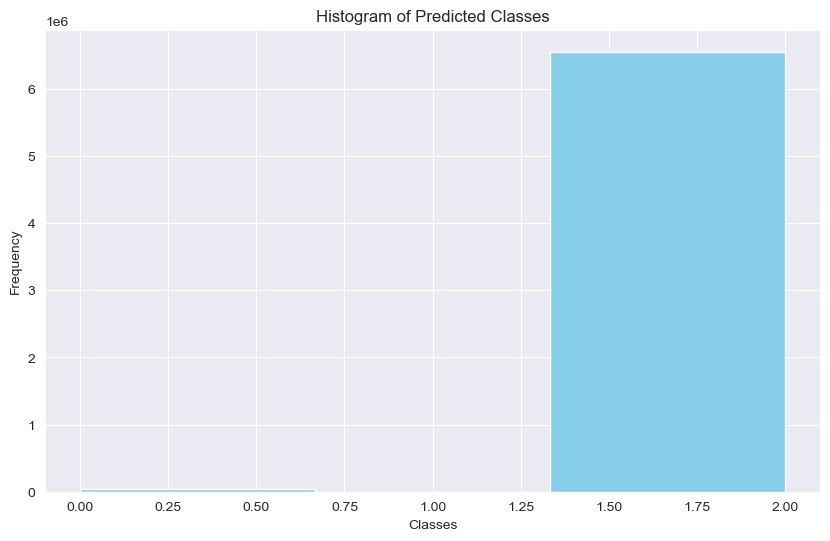

In [25]:
# Cell 22: Further Analysis and Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your trained neural network model
# and 'X_train' is your training dataset.

# Make sure the model is in evaluation mode and on the right device
model.eval()
model.to(device)  # Ensure the model is on the correct device

# Generate predictions
with torch.no_grad():
    # Ensure the data tensor is on the same device as the model
    outputs = model(X_train_tensor.to(device))
    _, predictions = torch.max(outputs, 1)

# Convert predictions to numpy array for use with matplotlib
predictions_np = predictions.cpu().numpy()

# Plotting the histogram of predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions_np, bins=len(np.unique(predictions_np)), color='skyblue')
plt.title('Histogram of Predicted Classes')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Additional analysis can be added here depending on the specific requirements or objectives of your project.


Shape of df4: (62232790, 45)

Counts of each label in df4:
 Label
TFTP             15750745
MSSQL             5563090
Syn               5495865
DrDoS_SNMP        4772055
DrDoS_DNS         4527409
DrDoS_MSSQL       4376070
UDP               3789881
DrDoS_NetBIOS     3608010
NetBIOS           3280843
DrDoS_UDP         3093625
DrDoS_SSDP        2568353
DrDoS_LDAP        1982487
LDAP              1719799
DrDoS_NTP         1195356
UDP-lag            330026
Portmap            177165
UDPLag               1572
WebDDoS               439
Name: count, dtype: int64


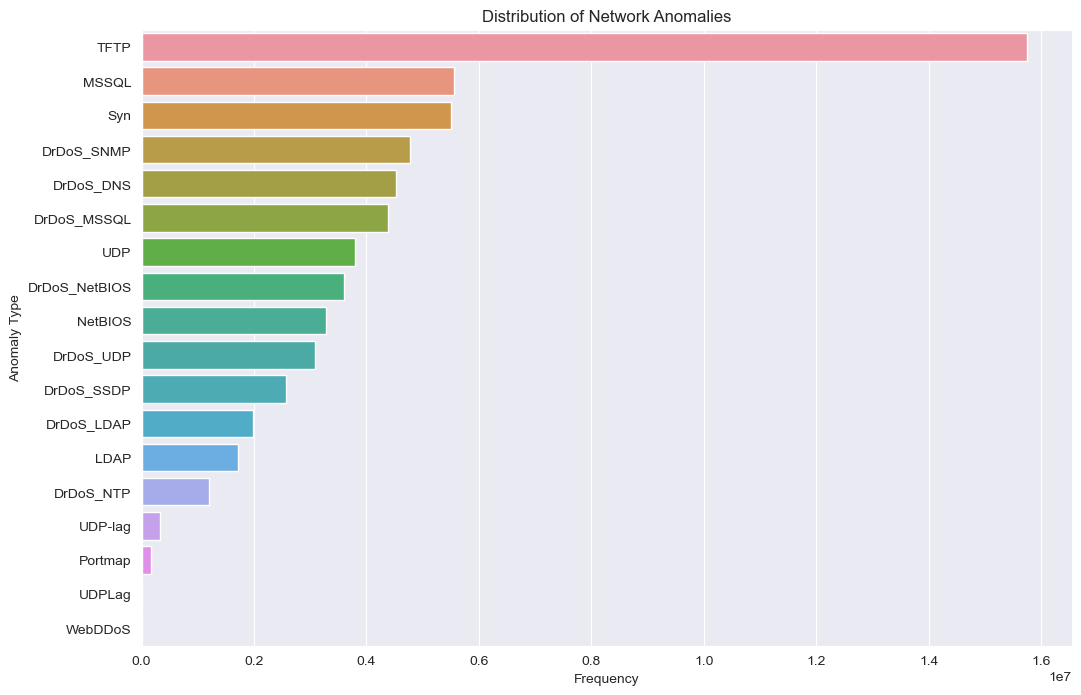

In [26]:
# Cell 23: Create DataFrame df4 with Network Anomalies Only

# Exclude 'BENIGN' traffic to focus only on network anomalies
df4 = df2[df2[' Label'] != 'BENIGN']

# Check the new shape and distribution of the labels
print("Shape of df4:", df4.shape)
print("\nCounts of each label in df4:")
print(df4[' Label'].value_counts())

# Plotting the distribution of network anomalies
plt.figure(figsize=(12, 8))
sns.countplot(y=df4[' Label'], order = df4[' Label'].value_counts().index)
plt.title('Distribution of Network Anomalies')
plt.xlabel('Frequency')
plt.ylabel('Anomaly Type')
plt.show()


In [27]:
# Cell 24: Clearing DataFrame 'df2' and 'df3' from memory

# Delete the DataFrames
del df2, df3

# Import the garbage collector module
import gc

# Manually trigger garbage collection to free up memory
gc.collect()

print("DataFrames 'df2' and 'df3' have been deleted and memory cleared.")


DataFrames 'df2' and 'df3' have been deleted and memory cleared.


First few rows of df4:
    Source Port   Destination Port   Protocol   Flow Duration  \
0           634              -5041         17           28415   
1           634              -5041         17               2   
2           634             -19145         17           48549   
3           634              11894         17           48337   
4           634              27878         17           32026   

    Total Fwd Packets   Total Backward Packets  Total Length of Fwd Packets  \
0                  97                        0                      42680.0   
1                   2                        0                        880.0   
2                 200                        0                      88000.0   
3                 200                        0                      88000.0   
4                 200                        0                      88000.0   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                           0.0                   44

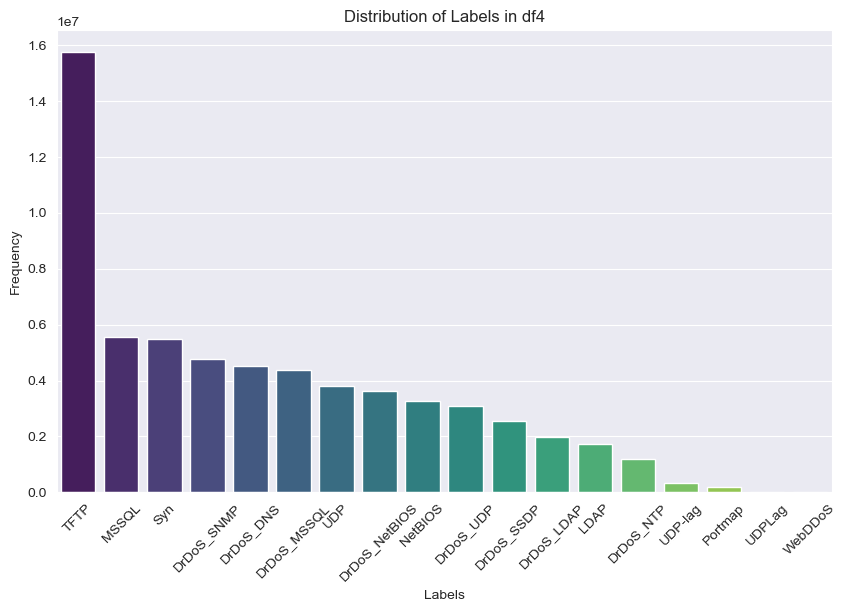


Descriptive Statistics:
        Source Port   Destination Port      Protocol   Flow Duration  \
count  6.223279e+07       6.223279e+07  6.223279e+07    6.223279e+07   
mean  -3.203564e+03      -7.021587e+00  1.595120e+01    1.292047e+06   
std    1.263806e+04       1.893858e+04  3.230926e+00    6.662546e+06   
min   -3.276800e+04      -3.276800e+04  0.000000e+00    1.000000e+00   
25%   -7.303000e+03      -1.642200e+04  1.700000e+01    1.000000e+00   
50%   -1.815000e+03      -1.150000e+02  1.700000e+01    2.000000e+00   
75%    8.340000e+02       1.644400e+04  1.700000e+01    1.057240e+05   
max    3.276700e+04       3.276700e+04  1.700000e+01    1.200000e+08   

        Total Fwd Packets   Total Backward Packets  \
count        6.223279e+07             6.223279e+07   
mean         4.060399e+00             8.827608e-02   
std          7.018839e+01             6.876143e-01   
min         -3.244500e+04             0.000000e+00   
25%          2.000000e+00             0.000000e+00   
50

In [28]:
# Cell 25: Inspect DataFrame and Check Environment

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import psutil

# Check if df4 is defined and display its first few rows, shape, and label distribution
if 'df4' in locals():
    print("First few rows of df4:")
    print(df4.head())
    print("\nShape of df4:", df4.shape)

    # Display label distribution
    print("\nLabel distribution in df4:")
    label_counts = df4[' Label'].value_counts()  # Adjust the column name if necessary
    print(label_counts)

    # Plotting the label distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Distribution of Labels in df4')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    # Display descriptive statistics for numerical features
    print("\nDescriptive Statistics:")
    print(df4.describe())
else:
    print("df4 is not defined.")

# Display current memory usage
process = psutil.Process(os.getpid())
print(f"Current memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")


In [29]:
# Cell 26: Splitting Data into Training and Testing Sets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Features and Labels
X = df4.drop(' Label', axis=1)  # Drop the label column to isolate features
y = df4[' Label']  # Isolate the label column

# Encoding the Labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the data
# We use stratify to ensure our training and test sets have approximately the same percentage of samples of each target class as the complete set.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Printing shapes of the splits to verify
print(f'Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}')


Training set shape: X_train: (49786232, 44), y_train: (49786232,)
Test set shape: X_test: (12446558, 44), y_test: (12446558,)


In [30]:
# Cell 27: Define the Basic Neural Network Model

def __init__(self, input_size, output_size):
    super(BasicNN, self).__init__()
    self.layer1 = nn.Linear(input_size, 64)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(64, output_size)
    self.sigmoid = nn.Sigmoid()  # Only use if output_size == 1 for binary classification
    self.initialize_weights()

def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.layer2(x)
    if self.layer2.out_features == 1:  # Assuming binary classification
        x = self.sigmoid(x)
    return x

def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to the correct device
model = BasicNN(input_size=X_train.shape[1], output_size=len(np.unique(y_train)))
model.to(device)

print("Model defined.")


Model defined.


In [31]:
# Cell 28: Train the Model

# Convert training data to tensors and move them to the appropriate device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        if epoch % 1 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Start training
train_model(model, criterion, optimizer, train_loader, epochs=3)


Epoch 1/3, Loss: 2.5001027584075928
Epoch 2/3, Loss: 2.430440664291382
Epoch 3/3, Loss: 2.111238718032837


C:\Users\gsmit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gsmit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gsmit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2531
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    905482
           1       0.00      0.00      0.00    396497
           2       0.00      0.00      0.00    875214
           3       0.00      0.00      0.00    239071
           4       0.00      0.00      0.00    721602
           5       0.00      0.00      0.00    954411
           6       0.00      0.00      0.00    513671
           7       0.00      0.00      0.00    618725
           8       0.00      0.00      0.00    343960
           9       0.00      0.00      0.00   1112618
          10       0.00      0.00      0.00    656169
          11       0.00      0.00      0.00     35433
          12       0.25      0.00      0.00   1099173
          13       0.25      1.00      0.40   3150149
          14       0.00      0.00      0.00    757976
          15       0.00      0.00      0.00     66005
          16       0.00      0.00      0

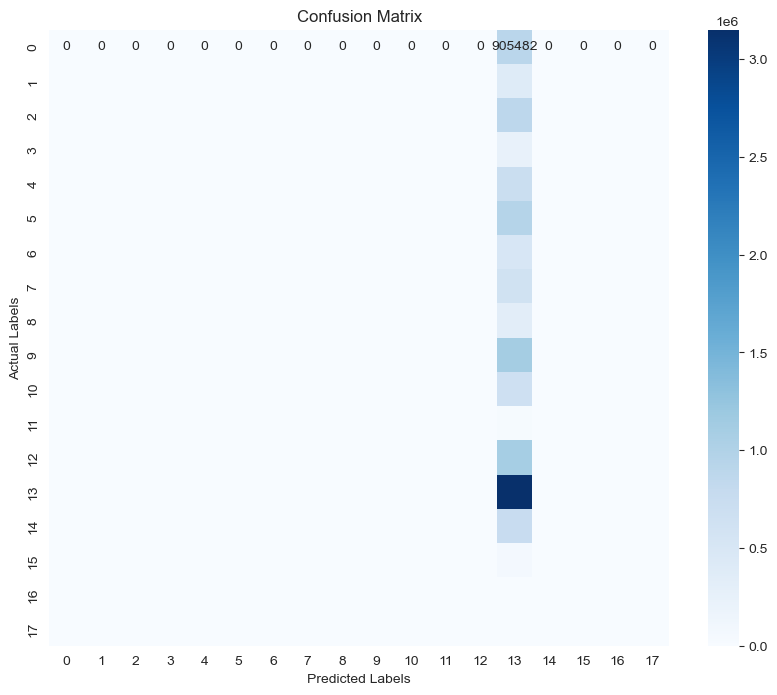

In [32]:
# Cell 29: Enhanced Model Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Move the model to CPU for evaluation
model.to('cpu')

# Convert test data to tensors and ensure they are on the CPU
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Disable gradient calculation for evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

# Calculating performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Converting tensors to numpy arrays for use with sklearn functions
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculating accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_np, predictions_np)
class_report = classification_report(y_test_np, predictions_np, target_names=np.unique(y_test).astype(str))

# Display metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, predictions_np)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


Accuracy: 0.2531
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    905482
           1       0.00      0.00      0.00    396497
           2       0.00      0.00      0.00    875214
           3       0.00      0.00      0.00    239071
           4       0.00      0.00      0.00    721602
           5       0.00      0.00      0.00    954411
           6       0.00      0.00      0.00    513671
           7       0.00      0.00      0.00    618725
           8       0.00      0.00      0.00    343960
           9       0.00      0.00      0.00   1112618
          10       0.00      0.00      0.00    656169
          11       0.00      0.00      0.00     35433
          12       0.25      0.00      0.00   1099173
          13       0.25      1.00      0.40   3150149
          14       0.00      0.00      0.00    757976
          15       0.00      0.00      0.00     66005
          16       0.00      0.00      0

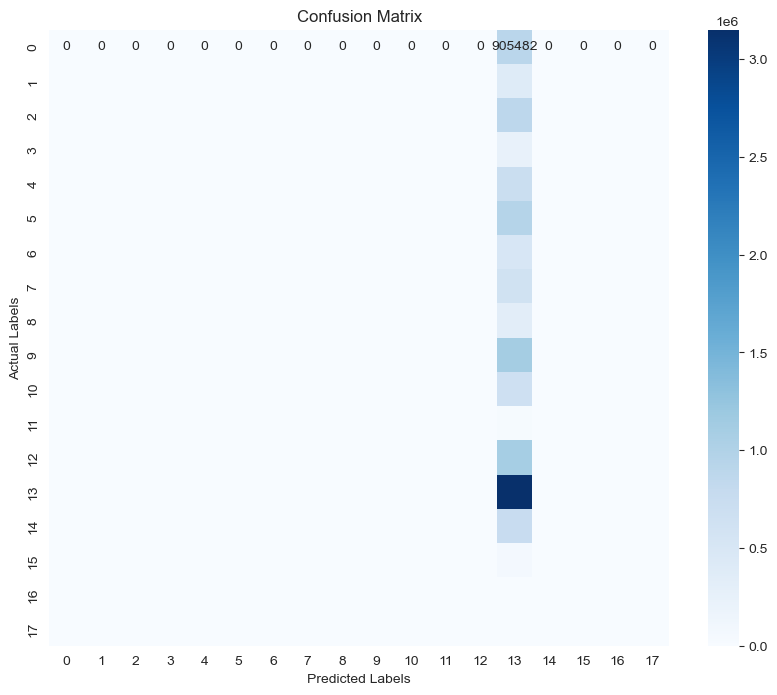

In [33]:
# Cell 29: Enhanced Model Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Convert test data to tensors and ensure they are on the CPU
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Disable gradient calculation for evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

# Calculating performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Converting tensors to numpy arrays for use with sklearn functions
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculating accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_np, predictions_np)
class_report = classification_report(y_test_np, predictions_np, target_names=np.unique(y_test).astype(str), zero_division=0)

# Display metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, predictions_np)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [34]:
# Cell 30: Define a More Complex BNN
class ComplexNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(ComplexNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.layer3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.layer1(x)))
        x = self.dropout2(self.relu2(self.layer2(x)))
        x = self.layer3(x)
        return x

# Instantiate the model
input_size = 44  # Adjust this based on the number of features
output_size = len(np.unique(y_train))  # Adjust this based on the number of unique labels/classes

model = ComplexNN(input_size, output_size).to(device)
print("Complex model defined and moved to:", device)


Complex model defined and moved to: cuda


In [35]:
# Cell 31: Train the More Complex BNN
def train_complex_model(model, criterion, optimizer, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Assuming train_loader is already defined
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_complex_model(model, criterion, optimizer, train_loader, epochs=10)


Epoch [1/10], Loss: 2.2193
Epoch [2/10], Loss: 2.6056
Epoch [3/10], Loss: 2.4256
Epoch [4/10], Loss: 2.3757
Epoch [5/10], Loss: 2.4370
Epoch [6/10], Loss: 2.3762
Epoch [7/10], Loss: 2.3988
Epoch [8/10], Loss: 2.4692
Epoch [9/10], Loss: 2.3926
Epoch [10/10], Loss: 2.4390


Accuracy: 0.2531
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    905482
           1       0.00      0.00      0.00    396497
           2       0.00      0.00      0.00    875214
           3       0.00      0.00      0.00    239071
           4       0.00      0.00      0.00    721602
           5       0.00      0.00      0.00    954411
           6       0.00      0.00      0.00    513671
           7       0.00      0.00      0.00    618725
           8       0.00      0.00      0.00    343960
           9       0.00      0.00      0.00   1112618
          10       0.00      0.00      0.00    656169
          11       0.00      0.00      0.00     35433
          12       0.00      0.00      0.00   1099173
          13       0.25      1.00      0.40   3150149
          14       0.00      0.00      0.00    757976
          15       0.00      0.00      0.00     66005
          16       0.00      0.00      0

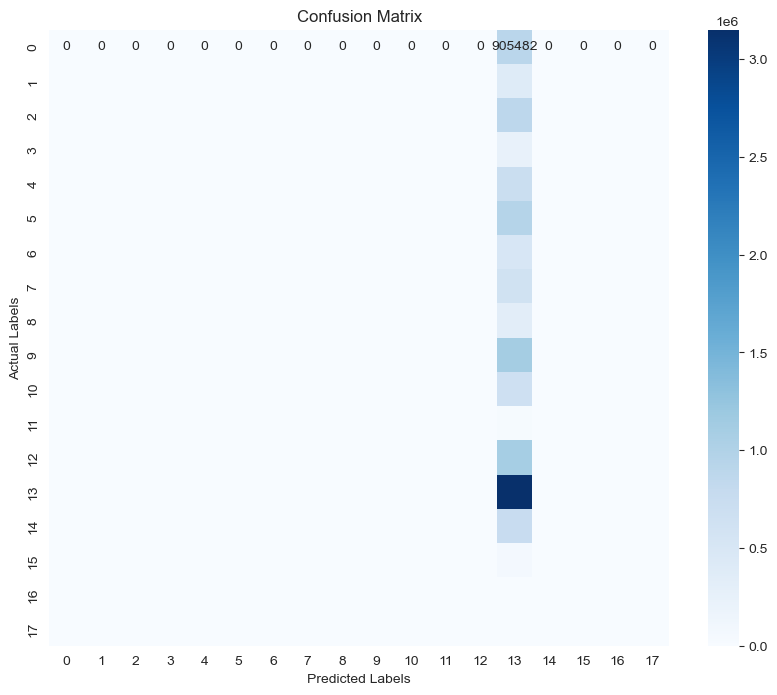

In [36]:
# Cell 32: Enhanced Model Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Move the model to CPU for evaluation
model.to('cpu')

# Convert test data to tensors and ensure they are on the CPU
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Disable gradient calculation for evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

# Calculating performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Converting tensors to numpy arrays for use with sklearn functions
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculating accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_np, predictions_np)
class_report = classification_report(y_test_np, predictions_np, target_names=np.unique(y_test).astype(str), zero_division=0)

# Display metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, predictions_np)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
